In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import menpo.io as mio
import scipy.io as sio
import functools

from pathlib import Path
from matplotlib import pyplot as plt

from menpo.image import Image
from menpo.shape import PointCloud
from menpofit.visualize import plot_cumulative_error_distribution
from menpofit.visualize import statistics_table
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap
from menpo.visualize import print_progress
# deep modules
import deepmachine as dm
from deepmachine.networks import pose
from deepmachine import networks
from deepmachine import utils
from deepmachine import losses
from deepmachine import summary
from deepmachine import data_provider
from deepmachine import contrib
from deepmachine import record_builder
from deepmachine import DeepMachine

import tensorflow as tf

slim = tf.contrib.slim

/Users/zha/miniconda2/envs/gitdev/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Convolutional Support Vector Shape

### build network

In [3]:
dense_pose_net_pb = DeepMachine()
dense_pose_net_pb.load_frozen_inception_graph('./models/denseRegPose/freezed.pb',return_elements=['uv:0'])

### Visualisation

In [4]:
def view_results(original_image, lms_hm_prediction, iuv, pts_predictions):
    
    plt.close()
    f_all = plt.figure(figsize=(10,8))



    f = plt.subplot(221)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

    img_pixel = original_image.pixels_with_channels_at_back()
    plt.imshow(img_pixel)



    f = plt.subplot(222)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

    hm_pixel = np.mean(lms_hm_prediction.squeeze(), axis=-1)
    plt.imshow(hm_pixel)

    
    f = plt.subplot(223)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)


    iuv_pixel = utils.convert.iuv_rgb(iuv, 'hsv')
    plt.imshow(iuv_pixel)

    f = plt.subplot(224)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)

    plt.scatter(pts_predictions[:,1], pts_predictions[:,0])
    plt.imshow(img_pixel * 0.3 + iuv_pixel * 0.7)
    
    return f_all

### Custom Image with Bounding Box

In [5]:
original_image = mio.import_image('/Users/zha/Downloads/WechatIMG62.jpeg')

original_image, *_ = utils.crop_image_bounding_box(original_image, PointCloud([[1202, 1271], [2645, 2752]]), [384,384])


h, w = original_image.shape
offset = (384-256)/2

original_image = original_image.crop((offset,offset),(offset+256,offset+256))

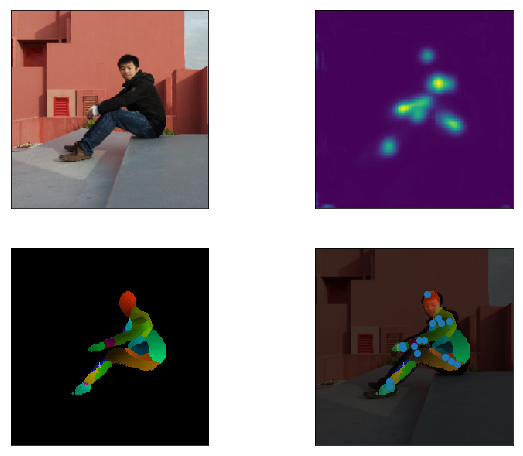

In [6]:
input_pixels = original_image.pixels_with_channels_at_back()

lms_hm_prediction,iuv = dense_pose_net_pb.run_one(input_pixels[None, ...].astype(np.float32))

bsize,h,w,n_ch = lms_hm_prediction.shape
lms_hm_prediction_filter = np.stack(list(map(
                            lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                            zip(lms_hm_prediction.transpose(0,3,1,2).reshape(-1,h,w), [5] * (bsize * n_ch)))))

hs = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 2), 1)
ws = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 1), 1)
pts_predictions = np.stack([hs,ws]).T

f = view_results(original_image, lms_hm_prediction, iuv, pts_predictions)